In [ ]:
# ============================================================
# STAGE 2 – INSTALLS (run once in this notebook)
# ============================================================
!pip install -q torch torchvision transformers datasets accelerate scikit-learn seaborn


In [ ]:
# ============================================================
# 1) IMPORTS + SEED
# ============================================================
import os
import json
import random
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler

from torchvision import transforms
from PIL import Image

from transformers import (
    SwinForImageClassification,
    AutoImageProcessor,
    Trainer,
    TrainingArguments,
    EvalPrediction,
)

from sklearn.metrics import (
    classification_report,
    accuracy_score,
    f1_score,
    confusion_matrix,
    roc_curve,
    auc
)
from sklearn.utils.class_weight import compute_class_weight

from google.colab import drive
import matplotlib.pyplot as plt
import seaborn as sns

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(42)
print("✅ Seed set to 42")


✅ Seed set to 42


In [ ]:
# ============================================================
# 2) PATHS (Drive + PREPROC + OUTPUT ROOT)
# ============================================================
drive.mount('/content/drive')

PREPROC_ROOT = "/content/drive/MyDrive/MultiBanFake/preprocessed"
OUTPUT_ROOT  = "/content/drive/MyDrive/MultiBanFake/outputs_swin_tiny"   # <-- Swin output folder
os.makedirs(PREPROC_ROOT, exist_ok=True)
os.makedirs(OUTPUT_ROOT, exist_ok=True)

print("PREPROC_ROOT:", PREPROC_ROOT)
print("OUTPUT_ROOT :", OUTPUT_ROOT)

Mounted at /content/drive
PREPROC_ROOT: /content/drive/MyDrive/MultiBanFake/preprocessed
OUTPUT_ROOT : /content/drive/MyDrive/MultiBanFake/outputs_swin_tiny


In [ ]:
# ============================================================
# 3) LOAD PREPROCESSED DATA (NPZ)
# ============================================================
train_npz = np.load(os.path.join(PREPROC_ROOT, "train_npz.npz"))
val_npz   = np.load(os.path.join(PREPROC_ROOT, "val_npz.npz"))
test_npz  = np.load(os.path.join(PREPROC_ROOT, "test_npz.npz"))

with open(os.path.join(PREPROC_ROOT, "classes.json"), "r") as f:
    classes = json.load(f)

print("Train images:", train_npz["images"].shape, "labels:", train_npz["labels"].shape)
print("Val images  :", val_npz["images"].shape,   "labels:", val_npz["labels"].shape)
print("Test images :", test_npz["images"].shape,  "labels:", test_npz["labels"].shape)
print("Classes:", classes)

num_labels = len(classes)
label_names = classes
label2id = {name: i for i, name in enumerate(label_names)}
id2label = {i: name for name, i in label2id.items()}


Train images: (7603, 224, 224, 3) labels: (7603,)
Val images  : (957, 224, 224, 3) labels: (957,)
Test images : (957, 224, 224, 3) labels: (957,)
Classes: ['Fake', 'Real']


In [ ]:
# ============================================================
# 4) DATASET CLASS (preprocessed numpy + dynamic augmentation)
# ============================================================
class CachedImageDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        # images: numpy [N, H, W, C], uint8
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return self.images.shape[0]

    def __getitem__(self, idx):
        img = self.images[idx]          # [H, W, C], uint8
        lbl = int(self.labels[idx])

        img = Image.fromarray(img)      # numpy -> PIL
        if self.transform:
            img = self.transform(img)   # aug + ToTensor + Normalize

        return {
            "pixel_values": img,
            "labels": torch.tensor(lbl, dtype=torch.long)
        }



In [ ]:
# ============================================================
# 5) TRANSFORMS (Swin-friendly, augmentation + eval)
# ============================================================
MODEL_NAME = "microsoft/swin-tiny-patch4-window7-224"

processor = AutoImageProcessor.from_pretrained(MODEL_NAME)

size_conf = processor.size
if isinstance(size_conf, dict):
    img_size = size_conf.get("shortest_edge") or size_conf.get("height") or 384
else:
    img_size = size_conf
print("Using image size:", img_size)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(img_size, scale=(0.9, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

eval_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize(mean=processor.image_mean, std=processor.image_std),
])

train_ds = CachedImageDataset(
    images=train_npz["images"],
    labels=train_npz["labels"],
    transform=train_transform,
)
val_ds = CachedImageDataset(
    images=val_npz["images"],
    labels=val_npz["labels"],
    transform=eval_transform,
)
test_ds = CachedImageDataset(
    images=test_npz["images"],
    labels=test_npz["labels"],
    transform=eval_transform,
)

print("Train dataset size:", len(train_ds))
print("Val dataset size  :", len(val_ds))
print("Test dataset size :", len(test_ds))


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/255 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Using image size: 224
Train dataset size: 7603
Val dataset size  : 957
Test dataset size : 957


In [ ]:
# ============================================================
# 6) IMBALANCE HANDLING (class weights + sample weights)
# ============================================================
train_labels = train_npz["labels"]
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(train_labels),
    y=train_labels,
)
print("Class weights:", class_weights)

sample_weights = np.array([class_weights[label] for label in train_labels], dtype=np.float64)
sample_weights_torch = torch.from_numpy(sample_weights)
print("Sample weights shape:", sample_weights_torch.shape)

Class weights: [1.00224097 0.99776903]
Sample weights shape: torch.Size([7603])


In [ ]:
# ============================================================
# 7) SWIN MODEL LOAD  (FIXED)
# ============================================================
swin_model = SwinForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels,        # <-- 2 for Fake/Real
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True  # <-- REQUIRED FIX
)

print("Loaded Swin model:", MODEL_NAME)


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/113M [00:00<?, ?B/s]

Some weights of SwinForImageClassification were not initialized from the model checkpoint at microsoft/swin-tiny-patch4-window7-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Loaded Swin model: microsoft/swin-tiny-patch4-window7-224


In [ ]:
# ============================================================
# 8) METRICS
# ============================================================
def compute_metrics(eval_pred: EvalPrediction):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)

    acc = accuracy_score(labels, preds)
    f1_weighted = f1_score(labels, preds, average="weighted")

    return {
        "accuracy": acc,
        "f1_weighted": f1_weighted,
    }

In [ ]:
# ============================================================
# 9) CUSTOM TRAINER (sampler + class-weight + label smoothing)
# ============================================================
class CustomTrainer(Trainer):
    def __init__(self, *args, class_weights=None, sample_weights=None, **kwargs):
        """
        CustomTrainer:
          - class_weights: used in CrossEntropyLoss (for class imbalance)
          - sample_weights: used in WeightedRandomSampler
        """
        super().__init__(*args, **kwargs)

        # ----- class_weights -----
        if class_weights is not None:
            if isinstance(class_weights, torch.Tensor):
                self.class_weights = class_weights.detach().clone().float()
            else:
                self.class_weights = torch.tensor(class_weights, dtype=torch.float)
        else:
            self.class_weights = None

        # ----- sample_weights -----
        if sample_weights is not None:
            if isinstance(sample_weights, torch.Tensor):
                self.sample_weights = sample_weights.detach().clone().double()
            else:
                self.sample_weights = torch.tensor(sample_weights, dtype=torch.double)
        else:
            self.sample_weights = None

    def compute_loss(
        self,
        model,
        inputs,
        return_outputs: bool = False,
        num_items_in_batch: int | None = None,
    ):
        """
        HF Trainer এখন compute_loss(..., num_items_in_batch=...) call করে।
        তাই signature-এ num_items_in_batch রাখতে হবে।
        """
        labels = inputs.pop("labels")
        outputs = model(**inputs)
        logits = outputs.logits

        if self.class_weights is not None:
            cw = self.class_weights.to(logits.device)
            loss_fct = nn.CrossEntropyLoss(weight=cw, label_smoothing=0.1)
        else:
            loss_fct = nn.CrossEntropyLoss(label_smoothing=0.1)

        loss = loss_fct(logits, labels)

        if return_outputs:
            return loss, outputs
        return loss

    def get_train_dataloader(self):
        """
        train dataloader override করে WeightedRandomSampler use করছি,
        যাতে imbalanced dataset handle করা যায়।
        """
        if self.sample_weights is None:
            return super().get_train_dataloader()

        if isinstance(self.train_dataset, torch.utils.data.IterableDataset):
            return super().get_train_dataloader()

        sampler = WeightedRandomSampler(
            weights=self.sample_weights,
            num_samples=len(self.sample_weights),
            replacement=True,
        )

        return DataLoader(
            self.train_dataset,
            batch_size=self.args.train_batch_size,
            sampler=sampler,
            collate_fn=self.data_collator,
            drop_last=self.args.dataloader_drop_last,
            num_workers=self.args.dataloader_num_workers,
            pin_memory=self.args.dataloader_pin_memory,
        )

In [ ]:
# ============================================================
# 10) TRAINING ARGUMENTS  (RE-RUN THIS!)
# ============================================================

output_dir = os.path.join(OUTPUT_ROOT, "swin_model_full")
os.makedirs(output_dir, exist_ok=True)

training_args = TrainingArguments(
    output_dir=output_dir,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    learning_rate=3e-5,
    weight_decay=0.01,

    # compatible with old HF
    eval_steps=500,
    save_steps=500,
    logging_steps=50,

    fp16=True,
    save_total_limit=2,
    remove_unused_columns=False,
)

print("TrainingArguments loaded for Swin!")

TrainingArguments loaded for Swin!


In [ ]:
# ============================================================
# 11) TRAIN SWIN,15a26bfde02e39ba547185222150f57c5c5d8e02
# ============================================================

trainer = CustomTrainer(
    model=swin_model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    compute_metrics=compute_metrics,

    class_weights=class_weights,
    sample_weights=sample_weights_torch,
)

trainer.train()

# ---- SAVE BEST MODEL ----
best_model_dir = os.path.join(OUTPUT_ROOT, "swin_tiny_best_model")
os.makedirs(best_model_dir, exist_ok=True)
trainer.save_model(best_model_dir)

print("✅ Saved best Swin model to:", best_model_dir)


/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zarin-cse-20210104111 (zarin-cse-20210104111-ahsanullah-university-of-science-t) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
50,0.722700
100,0.672600
150,0.669400
200,0.679200
250,0.656400
300,0.651200
350,0.645800
400,0.638900
450,0.626900
500,0.634100


✅ Saved best Swin model to: /content/drive/MyDrive/MultiBanFake/outputs_swin_tiny/swin_tiny_best_model



📊 Classification Report (Swin):

              precision    recall  f1-score   support

        Fake     0.6268    0.5388    0.5795       477
        Real     0.5978    0.6813    0.6368       480

    accuracy                         0.6102       957
   macro avg     0.6123    0.6100    0.6081       957
weighted avg     0.6123    0.6102    0.6082       957



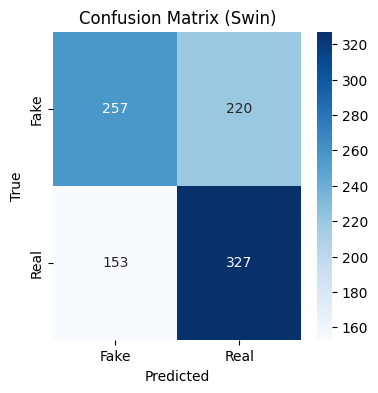

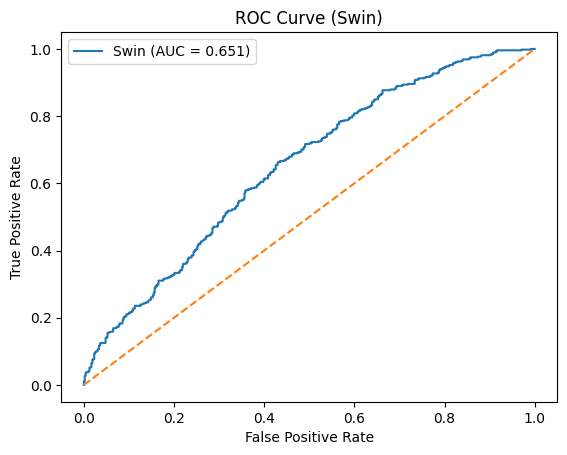


✅ Saved Swin report to: /content/drive/MyDrive/MultiBanFake/outputs_swin_tiny/swin_classification_report_full.json
✅ Saved Swin probs to : /content/drive/MyDrive/MultiBanFake/outputs_swin_tiny/swin_stack_probs_full.json


In [ ]:
# ============================================================
# 12) RICH EVAL + SAVE (REPORT + CONFUSION + ROC + PROBS)
# ============================================================
swin_preds = trainer.predict(test_ds)
logits = swin_preds.predictions
swin_pred_labels = np.argmax(logits, axis=-1)
swin_true_labels = swin_preds.label_ids

print("\n📊 Classification Report (Swin):\n")
print(classification_report(
    swin_true_labels,
    swin_pred_labels,
    target_names=label_names,
    digits=4
))

cm = confusion_matrix(swin_true_labels, swin_pred_labels)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (Swin)")
plt.show()

# ROC + probs (binary case)
if num_labels == 2:
    swin_probs_arr = torch.softmax(torch.tensor(logits), dim=-1).numpy()
    fpr, tpr, _ = roc_curve(swin_true_labels, swin_probs_arr[:, 1])
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, label=f"Swin (AUC = {roc_auc:.3f})")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve (Swin)")
    plt.legend()
    plt.show()
else:
    swin_probs_arr = torch.softmax(torch.tensor(logits), dim=-1).numpy()

# ---- Save report + probs ----
swin_report_dict = classification_report(
    swin_true_labels,
    swin_pred_labels,
    target_names=label_names,
    digits=4,
    output_dict=True,
)

swin_report_path = os.path.join(OUTPUT_ROOT, "swin_classification_report_full.json")
swin_probs_path  = os.path.join(OUTPUT_ROOT, "swin_stack_probs_full.json")

with open(swin_report_path, "w") as f:
    json.dump(swin_report_dict, f, indent=4)

swin_probs_list = swin_probs_arr.tolist()
with open(swin_probs_path, "w") as f:
    json.dump({
        "swin_probs": swin_probs_list,
        "true_labels": swin_true_labels.tolist()
    }, f)

print("\n✅ Saved Swin report to:", swin_report_path)
print("✅ Saved Swin probs to :", swin_probs_path)

In [ ]:
# ============================================================
# 13) SOFTMAX PROBABILITY (VAL + TEST) DIRECT SAVE FOR ENSEMBLE
# ============================================================
from transformers import SwinForImageClassification
import torch.nn.functional as F

device = "cuda" if torch.cuda.is_available() else "cpu"

BEST_MODEL_PATH = best_model_dir  # same as above

model = SwinForImageClassification.from_pretrained(BEST_MODEL_PATH).to(device)
model.eval()

print("Loaded best Swin model for softmax extraction!")

@torch.no_grad()
def get_softmax_probs(model, dataloader, device):
    all_probs = []
    all_labels = []

    model.eval()

    for batch in dataloader:
        imgs = batch["pixel_values"].to(device)
        labels = batch["labels"].cpu().numpy()

        outputs = model(imgs)
        logits = outputs.logits  # [B, num_labels]

        probs = F.softmax(logits, dim=-1).cpu().numpy()

        all_probs.append(probs)
        all_labels.append(labels)

    all_probs = np.concatenate(all_probs, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_probs, all_labels

# val_ds, test_ds already defined with eval_transform
val_dataloader  = DataLoader(val_ds,  batch_size=32, shuffle=False)
test_dataloader = DataLoader(test_ds, batch_size=32, shuffle=False)

print("VAL batches :", len(val_dataloader))
print("TEST batches:", len(test_dataloader))

val_probs, val_labels = get_softmax_probs(model, val_dataloader, device)
test_probs, test_labels = get_softmax_probs(model, test_dataloader, device)

print("Softmax shapes (val, test):", val_probs.shape, test_probs.shape)

SAVE_DIR = "/content/drive/MyDrive/MultiBanFake/swin_1_outputs"
os.makedirs(SAVE_DIR, exist_ok=True)

np.save(os.path.join(SAVE_DIR, "val_probs.npy"),  val_probs)
np.save(os.path.join(SAVE_DIR, "val_labels.npy"), val_labels)
np.save(os.path.join(SAVE_DIR, "test_probs.npy"), test_probs)
np.save(os.path.join(SAVE_DIR, "test_labels.npy"), test_labels)

print("✅ Saved softmax probabilities to:", SAVE_DIR)

Loaded best Swin model for softmax extraction!
VAL batches : 30
TEST batches: 30
Softmax shapes (val, test): (957, 2) (957, 2)
✅ Saved softmax probabilities to: /content/drive/MyDrive/MultiBanFake/swin_1_outputs
